# Process QChem AIMD scratch files

In [1]:
import numpy as np
import re
from sgdml.utils import io
from sgdml.predict import GDMLPredict
from sgdml.utils import io, ui
import argparse
import os
import sys
from sgdml import __version__
# from ase.io import read

In [2]:
from datascience import *
import pandas as pd
import matplotlib
from matplotlib import patches
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)
plt.style.use('ggplot')

[INFO] NumExpr defaulting to 4 threads.


### Function: Read QChem output file

In [3]:
def MDStep(file_name):
    # Some regex expressions
    num_str = re.compile('[+-]?\d+\.?\d*') # to find numbers
    time=re.compile(r'Time\s\(fs\)\s+(\d+\.\d+)')
    findforce=re.compile(r'Forces \(Hartrees\/Bohr\)')
    timestep = re.compile(r'TIME STEP #(\d+)\s\(t = (d\.\d+)\sa.u.\s=\s(d+\.\d+)')
    coord=re.compile(r'X=\s+([-]?\d\.\d+)D([+-]+\d+)\sY=\s+([-]?\d\.\d+)D([+-]+\d+)\sZ=\s+([-]?\d\.\d+)D([+-]+\d+)')
    endcoord=re.compile(r'MW cartesian velocity\:')
    #######
    temp = []
    time = []
    energy = []
    crd = [] # store coordinates in 2D array
    atoms = []
    s = 1.0
    step = 0
    startdyn = 0
    with open(file_name, 'r') as Qfile:
        data=Qfile.readlines()
    for i in range(len(data)):
        # TIME STEP #1 (t = 0.000 a.u. = 0.00000 fs)
        if i==8:
             print(i,data[i])
        if re.search(r'TIME STEP #',data[i]):
            fsec = float(re.findall(r'=\s(\d+\.\d+)\sfs',data[i])[0])
            time.append(fsec)
            startdyn = 1
            # Instantaneous Temperature = 291.9 K
        if re.search(r'Instantaneous Temperature =',data[i]):
            temperature = float(re.findall(r'=\s(\d+\.\d+)\sK',data[i])[0])
            temp.append(temperature)
            i+=1 # Move forward to coordinates
            #    1      O       1.3875858765     0.0114645102     0.1090411228
            #    2      H       1.7395762231     0.7248323964    -0.4529874171
            #    3      H       1.7383622270    -0.7920238234    -0.2840530212
            cols = []
            a = []
            i+=4 # skip forward to geometry
            while re.search(r'----',data[i]) is None: 
                atom = re.findall(r'\s([A-Z])\s',data[i])
                a.append(atom)
                sx=re.findall(r'([-]?\d\.\d+)\s+',data[i])
                cols.append(list(s*(1.0) for s in list(map(float, sx[0:3]))))                
                i+=1
            crd.append(cols)
            atoms.append(a)
        ## Find energy
        if re.search(r'Total energy in the final basis set = ',data[i]):
            total_energy = float(re.findall(r'=\s+([-]?\d+\.\d+)',data[i])[0])
            energy.append(total_energy) 
    print("Completed read of file\n Coordinates, time(fsec), temperature(K), energy(Hartree) returned...")
    
    sR = np.array(crd)
    energy = energy[1:]
    return sR,time,temp,energy,atoms

### Function: Read QChem AIMD Scratch

In [66]:
def read_QChem_AIMD_scratch(NucCarts,NucForces,View,Energy):
    n_atoms = None

    R, z, E, F = [], [], [], []
    for i, line in enumerate(NucCarts.split('\n')):
        if i ==0:
            print("Heading labels: ",line)
        else:
            carts = line.strip().split()
            if len(carts)<2:
                break
            time = carts[0]
            n_atoms = int((len(carts)-1)/3)
            R.append(list(map(float, carts[1::])))
    ndata = np.shape(R)[0]
    for i, line in enumerate(NucForces.split('\n')):
        if i ==0:
            print("Heading labels: ",line)
        else:
            forces = line.strip().split()
            if len(forces)<(n_atoms*3+1):
                break
            time = forces[0]
            n_atoms = int((len(forces)-1)/3)
            F.append(list(map(float, forces[1::])))
    for i, line in enumerate(Energy.split('\n')):
        if i ==0:
            print("Heading labels: ",line)
        else:
            en = line.strip().split()
            if len(en) < 2:
                break
            time = en[0]
            if i > 9997:
                print(en[1].isnumeric(),en[1], line, en)
            if i > ndata-1:
                break
            E.append(float(en[1])) # 4th column of TandV, 3rd of Energy
    for i, line in enumerate(View.split('\n')):
        if i == 0:
            number = int(line)
            if number != n_atoms:
                print(number,n_atoms," Do not agree on number of atoms!")
                break
        elif i==1:
            continue
        elif i>n_atoms+1:
            break # read first time step only
        else:
            z.append(io._z_str_to_z_dict[line[0]])  # From sgdml io to convert letter to atomic number, from sgdml.utils import io
    print(z)
    F = np.hstack(F)
    fshape = np.shape(F)
    ts = int(fshape[0]/(n_atoms*3))
    print(fshape)
    F = -F.reshape(-1, n_atoms, 3)* 2547 #0.529 #627.5/0.529 #1185.8 # Remove negative sign to shift between gradient and force
    R = np.hstack(R)
    R = R[:fshape[0]] # Limit size of carts to that of forces
    R = R.reshape(-1,n_atoms, 3)
    E = np.array(E[:ts])*627.51 # Limit size of carts to that of forces
    print("Emax: %6.2f Emin: %6.2f" %(np.max(E),np.min(E)))
    Enorm = (E -np.min(E))
    plt.hist(Enorm)
    plt.title("Energy distribution")
    plt.savefig('EDist_h2o_read.png')
    z = np.array(z)
    print("Found", n_atoms," atoms and ",ts," time steps.")
    return (R, z, E, F)

Heading labels:  # Time/fs  Nuclear cartestian coordinates (angstroms)
Heading labels:  # Time/fs  Nuclear cartesian forces (a.u.)
Heading labels:  # Time/fs E(Total), V(Elec), V(One-E), V(Coul), V(Alpha Ex), V(Beta Ex), V(DFT Ex), V(DFT Corr), V(Nuc-Nuc), V(Nuc-Elec), T(Elec), T(Nuc), T(Fict)
False -4.60710322e+02 4836.317331  -4.60710322e+02  -4.60774932e+02  6.93524996e-310  3.45845952e-323  6.93525013e-310  4.94065646e-324  6.93525013e-310 6.93525013e-310  6.93525013e-310   0.00000000e+00  6.93524996e-310   6.46099371e-02   0.00000000e+00 ['4836.317331', '-4.60710322e+02', '-4.60774932e+02', '6.93524996e-310', '3.45845952e-323', '6.93525013e-310', '4.94065646e-324', '6.93525013e-310', '6.93525013e-310', '6.93525013e-310', '0.00000000e+00', '6.93524996e-310', '6.46099371e-02', '0.00000000e+00']
False -4.60710337e+02 4836.801108  -4.60710337e+02  -4.60776315e+02  6.93524996e-310  3.45845952e-323  6.93525013e-310  4.94065646e-324  6.93525013e-310 6.93525013e-310  6.93525013e-310   0.0

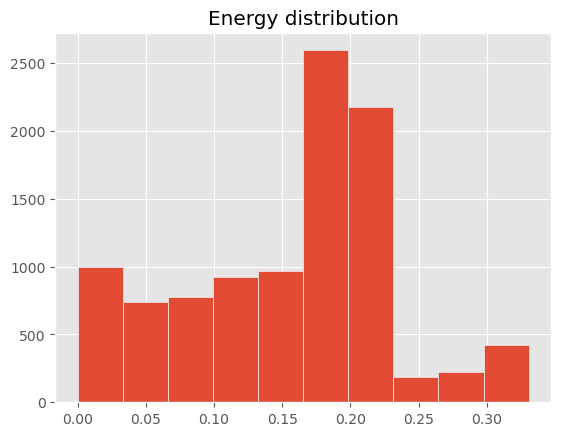

In [67]:
#sR,time,temp,energy,atoms = MDStep('data_h2o/h2o.out')
#Enorm = enery -np.max(energy)
#plt.hist(Enorm)
path = 'data_HCl'
Force = path+'/NucForces'
with open(Force, 'r') as file:
    NucForces = file.read()
Carts = path+'/NucCarts'
with open(Carts, 'r') as file:
    NucCarts = file.read()
View = path+'/View.xyz'
with open(View, 'r') as file:
    View = file.read()
#Energy = path+'/TandV' # Change from EComponents which are constant
# EComponents: Records various components of the total energy (all in hartree).
Energy = path+'/EComponents' # Change from EComponents which are constant
with open(Energy, 'r') as file:
    Energy = file.read()
R, z, E, F = read_QChem_AIMD_scratch(NucCarts,NucForces,View,Energy)
name = "H2O"
filename = name+"_AIMD"
# Base variables contained in every model file.


base_vars = {
    'type': 'd',
    'code_version': __version__,
    'name': name,
    'theory': 'QChem',
    'R': R,
    'z': z,
    'F': F,
}
base_vars['r_unit'] = 'Ang'
base_vars['e_unit'] = 'kcal/mol'

In [68]:
E

array([-289100.3266281 , -289100.24881686, -289100.12958996, ...,
       -289100.33415822, -289100.34357087, -289100.29901766])

### Look at Forces 
Compute numerically and compare to values given in F

In [69]:
from datascience import *

In [70]:
pwd

'/home/jovyan/MD_MLPES.git/code'

In [71]:
edata = Table.read_table('data/Energy')
edata

# Time/fs E(total) - E(prev) E(total) - E(initial)
0.000000 0.000000e+00 0.000000e+00
0.024189 -2.621618e-09 -2.621618e-09
0.048378 -2.460752e-09 -5.082370e-09
0.072567 -2.492300e-09 -7.574670e-09
0.096755 -2.512479e-09 -1.008715e-08
0.120944 -2.460581e-09 -1.254773e-08
0.145133 -2.328989e-09 -1.487672e-08
0.169322 -2.305455e-09 -1.718217e-08
0.193511 -2.298748e-09 -1.948092e-08
0.217700 -2.214790e-09 -2.169571e-08


In [72]:
edata[0]

array(['   0.000000     0.000000e+00     0.000000e+00',
       '   0.024189    -2.621618e-09    -2.621618e-09',
       '   0.048378    -2.460752e-09    -5.082370e-09', ...,
       '  48.619575    -7.144649e-10    -7.109759e-08',
       '  48.643764    -7.695462e-10    -7.186713e-08',
       '  48.667953    -8.064944e-10    -7.267363e-08'],
      dtype='<U45')

In [73]:
np.shape(F)

(10000, 2, 3)

In [74]:
z

array([1, 6])

In [75]:
F[100]

array([[ -1.44593106e-02,   4.37791554e-02,  -1.21838607e-03],
       [  4.16728804e-04,  -1.26175000e-03,   3.51148528e-05]])

In [76]:
DelE = E[101]-E[99]
DelE


-0.10165662004146725

In [10]:
R[100]

array([[-0.3935785 ,  1.166795  ,  0.00911785],
       [ 0.01134324, -0.03362795,  0.03633962]])

In [11]:
DelR = R[101]-R[99]
DelR

array([[-0.0318293 ,  0.093978  ,  0.1438237 ],
       [ 0.00091734, -0.00270851, -0.00414511]])

In [12]:
ssq = np.sqrt(np.sum(DelR**2))
ssq

0.1748015588608631

In [13]:
gradient = DelE/ssq
gradient

-20.989806921108805

In [14]:
-gradient*DelR

array([[-0.66809086,  1.97258007,  3.01883169],
       [ 0.01925479, -0.0568511 , -0.08700506]])

In [15]:
F[100]

array([[ -1.44593106e-02,   4.37791554e-02,  -1.21838607e-03],
       [  4.16728804e-04,  -1.26175000e-03,   3.51148528e-05]])

In [16]:
F[101]

array([[  7.85615377e-05,  -8.92374320e-05,   3.25490422e-05],
       [ -2.26420406e-06,   2.57188303e-06,  -9.38088629e-07]])

In [17]:
np.shape(F[:,0,0])

(10000,)

In [77]:
RHCl = np.sqrt(R[:][0])

In [23]:
R[1][0][0]

0.0239986339

In [24]:
R[1][1][0]

-0.00067228389999999996

In [33]:
R[:][1][0]

array([ 0.02332635, -0.0692519 ,  1.223649  ])

In [59]:
np.shape(R[:,1,1])

(10000,)

In [41]:
R[:][0][0]

array([-0.  ,  0.  ,  1.27])

In [65]:
R[:,0,2]

array([ 1.27    ,  1.223649,  1.184889, ..., -1.146276, -1.173171,
       -1.199836])

In [78]:
RHCl = np.sqrt((R[:,0,1]-R[:,0,0])**2+(R[:,1,1]-R[:,0,1])**2+(R[:,1,2]-R[:,0,2])**2)

In [79]:
np.shape(RHCl)

(10000,)

Text(0, 0.5, 'Energy')

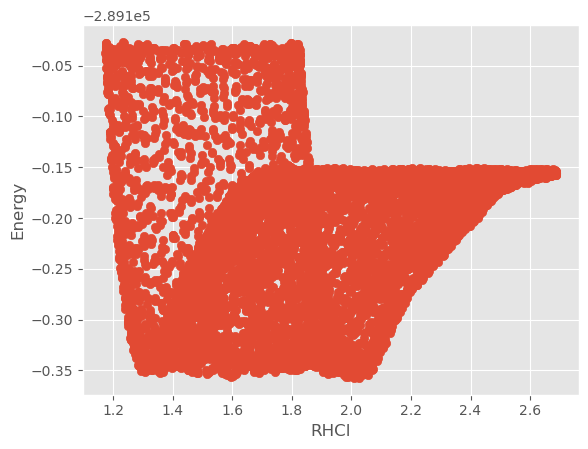

In [80]:
plt.scatter(RHCl,E[:])
plt.xlabel("RHCl")
plt.ylabel("Energy")

In [33]:
np.shape(E)

(10000,)

### Store data in sGDML .npz file

In [34]:
base_vars['F_min'], base_vars['F_max'] = np.min(F.ravel()), np.max(F.ravel())
base_vars['F_mean'], base_vars['F_var'] = np.mean(F.ravel()), np.var(F.ravel())

print('Please provide a description of the length unit used in your input file, e.g. \'Ang\' or \'au\': ')
print('Note: This string will be stored in the dataset file and passed on to models files for later reference.')
#base_vars['r_unit'] = 'Ang'

print('Please provide a description of the energy unit used in your input file, e.g. \'kcal/mol\' or \'eV\': ')
print('Note: This string will be stored in the dataset file and passed on to models files for later reference.')
#base_vars['e_unit'] = 'kcal/mol'

if E is not None:
    base_vars['E'] = E
    base_vars['E_min'], base_vars['E_max'] = np.min(E), np.max(E)
    base_vars['E_mean'], base_vars['E_var'] = np.mean(E), np.var(E)
else:
    print(ui.color_str('[INFO]', bold=True) + ' No energy labels found in dataset.')
keys = ['z', 'R', 'E', 'F']
for k in keys:
    d = base_vars[k]
    print(np.shape(d))
    if type(d) is np.ndarray:
            print(k)
            d = d.ravel()
            print(np.shape(d))
dataset_file_name = filename + '.npz'
base_vars['md5'] = io.dataset_md5(base_vars)
np.savez_compressed(dataset_file_name, **base_vars)
print(ui.color_str('[DONE]', fore_color=ui.GREEN, bold=True))

Please provide a description of the length unit used in your input file, e.g. 'Ang' or 'au': 
Note: This string will be stored in the dataset file and passed on to models files for later reference.
Please provide a description of the energy unit used in your input file, e.g. 'kcal/mol' or 'eV': 
Note: This string will be stored in the dataset file and passed on to models files for later reference.
(3,)
z
(3,)
(10000, 3, 3)
R
(90000,)
(10000,)
E
(10000,)
(10000, 3, 3)
F
(90000,)
[DONE]


In [11]:
def dataset_md5(dataset):

    md5_hash = hashlib.md5()

    keys = ['z', 'R']
    if 'E' in dataset:
        keys.append('E')
    keys.append('F')

    # only include new extra keys in fingerprint for 'modern' dataset files
    # 'code_version' was included from 0.4.0.dev1
    # opt_keys = ['lattice', 'e_unit', 'E_min', 'E_max', 'E_mean', 'E_var', 'f_unit', 'F_min', 'F_max', 'F_mean', 'F_var']
    # for k in opt_keys:
    #    if k in dataset:
    #        keys.append(k)

    for k in keys:
        d = dataset[k]
        if type(d) is np.ndarray:
            d = d.ravel()
        md5_hash.update(hashlib.md5(d).digest())

    return md5_hash.hexdigest().encode('utf-8')

In [50]:
dataset_file_name = filename + '.xyz'
try:
    with open(dataset_file_name, 'w') as file:

        n = R.shape[0]
        for i, r in enumerate(R):

            e = np.squeeze(base_vars['E'][i]) if 'E' in base_vars else None
            f = base_vars['F'][i,:,:]
            ext_xyz_str = io.generate_xyz_str(r, z, e=e, f=f) + '\n'

            file.write(ext_xyz_str)

            progr = float(i) / (n - 1)
            ui.callback(i, n - 1, disp_str='Exporting %d data points...' % n)
            
except IOError:
    sys.exit("ERROR: Writing xyz file failed.")

print()

[100%] Exporting 10000 data points...



In [17]:
from datascience import *
edata = Table().read_table('data_h2o_small/energy.csv')

In [18]:
edata

energy
-76.3857
-76.3859
-76.3859
-76.386
-76.386
-76.386
-76.3859
-76.3858
-76.3857
-76.3855


In [23]:
edata= edata.with_columns("Enorm",(edata['energy']-np.min(edata['energy']))*627.5)

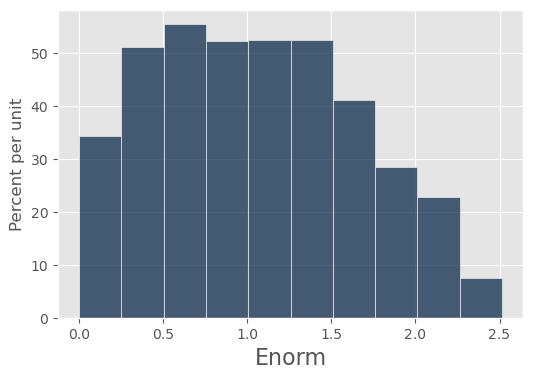

In [26]:
edata.hist('Enorm')
plt.savefig('EDist_h2o.png')